<a href="https://colab.research.google.com/github/zeppelin-slash/Python-Explorations/blob/main/Homework_4_Shruti_nlp_classification_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# ML model imports
from sklearn.linear_model import LogisticRegression # Logistic regression
from sklearn.naive_bayes import MultinomialNB # NAIVE BAYES
from sklearn.ensemble import RandomForestClassifier # Random forests

# Standard evaluation and splitting tools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Womens%20Clothing%20E-Commerce%20Reviews%20-%20Womens%20Clothing%20E-Commerce%20Reviews.csv')
data.head()

,Age,Title,Review Text,Recommended IND,Division Name,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,1,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,1,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,General,Tops,Blouses


The homework is to use the Review Text (and any other feature's you'd like) to predict whether someone will recommend (Recommended IND) a product or not.

# Have fun!

You are also welcome to use AutoML if you'd prefer (or both! :)

Data Exploration

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              23486 non-null  int64 
 1   Title            19676 non-null  object
 2   Review Text      22641 non-null  object
 3   Recommended IND  23486 non-null  int64 
 4   Division Name    23472 non-null  object
 5   Department Name  23472 non-null  object
 6   Class Name       23472 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.3+ MB


In [ ]:
#missing data
total = data.isna().sum().sort_values(ascending=False) 
percent = (data.isna().sum()/data.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(50)

,Total,Percent
Title,3810,0.162224
Review Text,845,0.035979
Class Name,14,0.000596
Department Name,14,0.000596
Division Name,14,0.000596
Recommended IND,0,0.000000
Age,0,0.000000


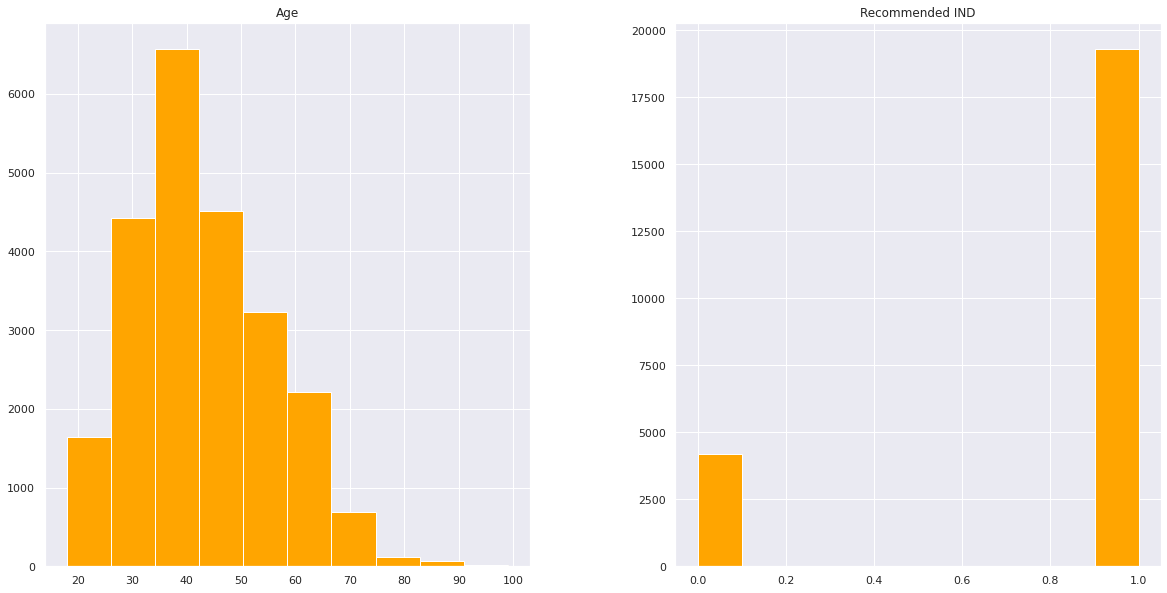

In [ ]:
data.hist(figsize = (20,10), color = 'orange')
plt.show()

Preprocessing to make Column Names Usable


In [ ]:
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ","")
data.head()

,Age,Title,ReviewText,RecommendedIND,DivisionName,DepartmentName,ClassName
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,1,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,1,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,General,Tops,Blouses


Add extra features

In [ ]:
#is review text missing? data['ReviewText'].str.contains(' ')
data['isReviewMissing'] = np.where(( data['ReviewText'].isna()), 1, 0)
#is title of review missing?
data['isTitleMissing'] = np.where((data['Title'].isna()),1,0)
#removing NaN values from text columns
data = data.replace(np.nan, '', regex=True)
data.head()
data['Exclamations'] = data.ReviewText.str.count("!") + data.Title.str.count("!") 
data.head(10)

,Age,Title,ReviewText,RecommendedIND,DivisionName,DepartmentName,ClassName,isReviewMissing,isTitleMissing,Exclamations
0,33,,Absolutely wonderful - silky and sexy and comf...,1,Initmates,Intimate,Intimates,0,1,0
1,34,,Love this dress! it's sooo pretty. i happene...,1,General,Dresses,Dresses,0,1,1
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0,0,1
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,General Petite,Bottoms,Pants,0,0,3
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,General,Tops,Blouses,0,0,3
5,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",0,General,Dresses,Dresses,0,0,0
6,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,0,0,0
7,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",1,General Petite,Tops,Knits,0,0,0
8,24,Flattering,I love this dress. i usually get an xs but it ...,1,General,Dresses,Dresses,0,0,0
9,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",1,General,Dresses,Dresses,0,0,1


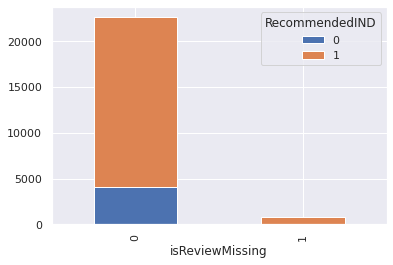

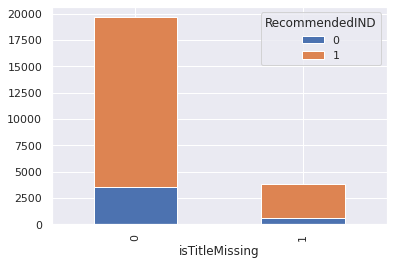

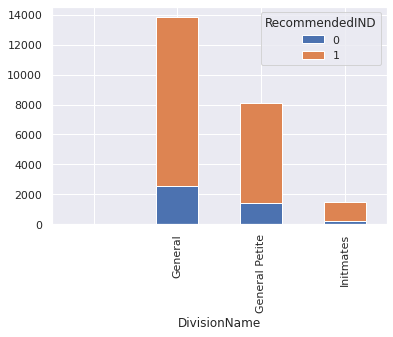

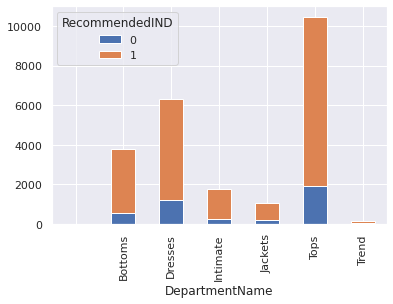

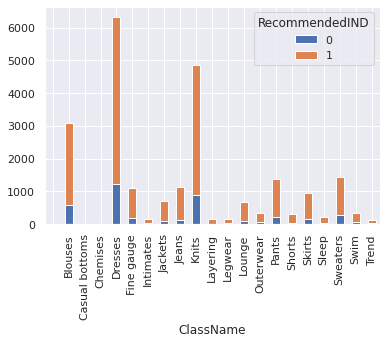

In [ ]:
#check for bias among Age and Division, dept , class, title missing , review words# , review word length, special characters

data.groupby(['isReviewMissing','RecommendedIND']).size().unstack().plot.bar(stacked=True)

data.groupby(['isTitleMissing','RecommendedIND']).size().unstack().plot.bar(stacked=True)

data.groupby(['DivisionName','RecommendedIND']).size().unstack().plot.bar(stacked=True)

data.groupby(['DepartmentName','RecommendedIND']).size().unstack().plot.bar(stacked=True)

data.groupby(['ClassName','RecommendedIND']).size().unstack().plot.bar(stacked=True)


In [ ]:
data = pd.get_dummies(data, columns=['ClassName'], drop_first=False)
data = pd.get_dummies(data, columns=['DepartmentName'], drop_first=False)
data = pd.get_dummies(data, columns=['DivisionName'], drop_first=False)
data.head()

,Age,Title,ReviewText,RecommendedIND,isReviewMissing,isTitleMissing,Exclamations,ClassName_,ClassName_Blouses,ClassName_Casual bottoms,ClassName_Chemises,ClassName_Dresses,ClassName_Fine gauge,ClassName_Intimates,ClassName_Jackets,ClassName_Jeans,ClassName_Knits,ClassName_Layering,ClassName_Legwear,ClassName_Lounge,ClassName_Outerwear,ClassName_Pants,ClassName_Shorts,ClassName_Skirts,ClassName_Sleep,ClassName_Sweaters,ClassName_Swim,ClassName_Trend,DepartmentName_,DepartmentName_Bottoms,DepartmentName_Dresses,DepartmentName_Intimate,DepartmentName_Jackets,DepartmentName_Tops,DepartmentName_Trend,DivisionName_,DivisionName_General,DivisionName_General Petite,DivisionName_Initmates
0,33,,Absolutely wonderful - silky and sexy and comf...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,34,,Love this dress! it's sooo pretty. i happene...,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


Text Column preprocessing

In [ ]:
## Checking for stopwords
stopwordSet = set(stopwords.words("english"))
stopwordSet
stop_data = {'dress', 'top', 'shirt' ,'pant' ,'pants', 'jeans' , 'jean' }
stop_data
stopwordSet.update(stop_data)
stopwordSet

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'dress',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'jean',
 'jeans',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',

In [ ]:
## NlP Processing
lemma = WordNetLemmatizer()

In [ ]:
def cleanup_sentances(sentence):
    text = re.sub('[^a-zA-Z]'," ", sentence) # Removing non a-z characters
    print(sentence) # Print out non-cleaned text
    text = text.lower() # Lowering all text
    text = word_tokenize(text, language="english") # Splitting each word into an element of a list
    text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet] # Lemmatizing words and removing stopwords
    text = " ".join(text) # Putting words back into a single string. ['the', 'brown', 'cow'] --> 'the brown cow'
    print(text, '\n') # Print out cleaned text
    return text

In [ ]:
data.head()


,Age,Title,ReviewText,RecommendedIND,isReviewMissing,isTitleMissing,Exclamations,ClassName_,ClassName_Blouses,ClassName_Casual bottoms,ClassName_Chemises,ClassName_Dresses,ClassName_Fine gauge,ClassName_Intimates,ClassName_Jackets,ClassName_Jeans,ClassName_Knits,ClassName_Layering,ClassName_Legwear,ClassName_Lounge,ClassName_Outerwear,ClassName_Pants,ClassName_Shorts,ClassName_Skirts,ClassName_Sleep,ClassName_Sweaters,ClassName_Swim,ClassName_Trend,DepartmentName_,DepartmentName_Bottoms,DepartmentName_Dresses,DepartmentName_Intimate,DepartmentName_Jackets,DepartmentName_Tops,DepartmentName_Trend,DivisionName_,DivisionName_General,DivisionName_General Petite,DivisionName_Initmates
0,33,,Absolutely wonderful - silky and sexy and comf...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,34,,Love this dress! it's sooo pretty. i happene...,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
#removing NaN values from text columns
data_noNaN = data.replace(np.nan, '', regex=True)
data_noNaN.head()

,Age,Title,ReviewText,RecommendedIND,isReviewMissing,isTitleMissing,Exclamations,ClassName_,ClassName_Blouses,ClassName_Casual bottoms,ClassName_Chemises,ClassName_Dresses,ClassName_Fine gauge,ClassName_Intimates,ClassName_Jackets,ClassName_Jeans,ClassName_Knits,ClassName_Layering,ClassName_Legwear,ClassName_Lounge,ClassName_Outerwear,ClassName_Pants,ClassName_Shorts,ClassName_Skirts,ClassName_Sleep,ClassName_Sweaters,ClassName_Swim,ClassName_Trend,DepartmentName_,DepartmentName_Bottoms,DepartmentName_Dresses,DepartmentName_Intimate,DepartmentName_Jackets,DepartmentName_Tops,DepartmentName_Trend,DivisionName_,DivisionName_General,DivisionName_General Petite,DivisionName_Initmates
0,33,,Absolutely wonderful - silky and sexy and comf...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,34,,Love this dress! it's sooo pretty. i happene...,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,47,Flattering shirt,This shirt is very flattering to all due to th...,1,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
data_noNaN['title_cleaned'] = data_noNaN.Title.apply(cleanup_sentances)

Streaming output truncated to the last 5000 lines.
 

Super cute, poor quality
super cute poor quality 

So cute! but way too boxy
cute way boxy 

Love this!
love 

Much longer than stated
much longer stated 


 


 

Exquisite and timeless
exquisite timeless 

Bulky
bulky 

Effortless elegance
effortless elegance 

Wanted to love it!
wanted love 

Perfect
perfect 

Very cute
cute 

Sooo sheer
sooo sheer 

Awesome look & feel
awesome look feel 

Love this skirt!
love skirt 

Great versatile dress
great versatile 

Cutest jacket ever
cutest jacket ever 


 

Exactly what i wanted!
exactly wanted 

So perfect if only the sides did not cut up
perfect side cut 

So soft
soft 

Go for the grey if you can still find it
go grey still find 

Beautiful dress but runs small
beautiful run small 

Nicely draped, beyond basic tank w/ tricky sizing
nicely draped beyond basic tank w tricky sizing 

Gorgeous
gorgeous 

Loving the lines...
loving line 


 

Strange armhole construction
strange armhole 

In [ ]:
data_noNaN.rename(columns={'Review Text': 'ReviewText', }, inplace=True)
data_noNaN['reviewtext_cleaned'] = data_noNaN.ReviewText.apply(cleanup_sentances)

Streaming output truncated to the last 5000 lines.
The shirt looks a lot less fitted on the model in the picture than how it fit in "real" life. size was not wrong, the material was just very clingy. i was not impressed and subsequently returned it.
look lot le fitted model picture fit real life size wrong material clingy impressed subsequently returned 

The title says it all...
perfect go-to tank for underneath tops. smooths out lines. purchased in a large, so if you're between sizes, may want to size up.
title say perfect go tank underneath top smooth line purchased large size may want size 

I was first attracted to this tunic by the beautiful, bright colors; tried it on, and it was becoming, comfortable, and perfect for my laid-back lifestyle. i just bought it a week ago, have worn it three times already. i bought the blue.
first attracted tunic beautiful bright color tried becoming comfortable perfect laid back lifestyle bought week ago worn three time already bought blue 

It ac

Using Word Cloud on cleaned Title

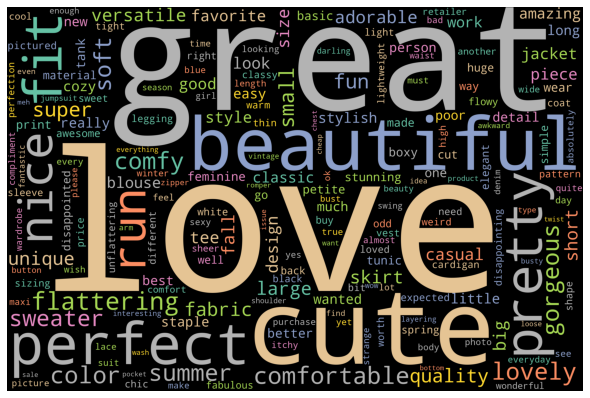

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
# Importing spacy
import spacy
# WordCloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Set2', 
                      collocations=False).generate(" ".join(list(data_noNaN['title_cleaned'])))

# Save image
wordcloud.to_file("wordcloud.png")

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

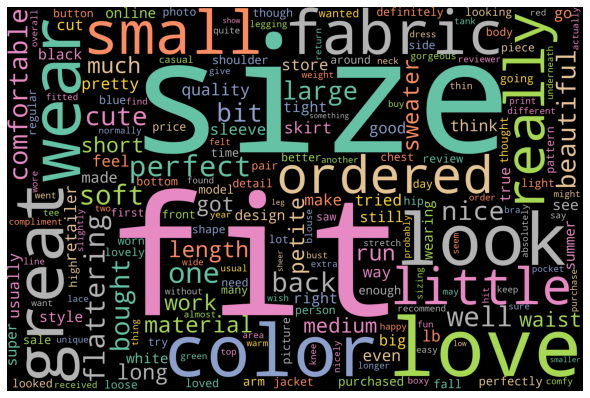

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
# Importing spacy
import spacy
# WordCloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Set2', 
                      collocations=False).generate(" ".join(list(data_noNaN['reviewtext_cleaned'])))

# Save image
wordcloud.to_file("wordcloud.png")

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Create Bag Of Words Model

In [ ]:
## Create the (B.O.W) bag of word model
cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(data_noNaN.reviewtext_cleaned).toarray()
X = pd.DataFrame(X, columns=cv.get_feature_names())
X.shape
X.head()

NameError: ignored

Splitting data in train, test groups

In [ ]:
data_noNaN.columns
data_noNaN_other = np.array(data_noNaN[['isReviewMissing',
       'isTitleMissing', 
       'DepartmentName_Bottoms', 'DepartmentName_Dresses',
       'DepartmentName_Intimate', 'DepartmentName_Jackets',
       'DepartmentName_Tops', 'DepartmentName_Trend', 'DivisionName_General',
       'DivisionName_General Petite', 'DivisionName_Initmates' ,'Exclamations']])
#df = pd.concat([X, data_noNaN_other])
#df.head()
#'ClassName_Blouses', 'ClassName_Casual bottoms',
 #      'ClassName_Chemises', 'ClassName_Dresses', 'ClassName_Fine gauge',
 #      'ClassName_Intimates', 'ClassName_Jackets', 'ClassName_Jeans',
 #      'ClassName_Knits', 'ClassName_Layering', 'ClassName_Legwear',
 #      'ClassName_Lounge', 'ClassName_Outerwear', 'ClassName_Pants',
 #      'ClassName_Shorts', 'ClassName_Skirts', 'ClassName_Sleep',
  #     'ClassName_Sweaters', 'ClassName_Swim', 'ClassName_Trend',#
data_noNaN_other.shape

(23486, 12)

In [ ]:
X_arr = np.concatenate((X, data_noNaN_other), axis=1)
#pd.DataFrame(X_arr, columns=cv.get_feature_names()).head(100)
X_arr.shape

(23486, 2012)

In [ ]:
y= data_noNaN['RecommendedIND']

## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X_arr, y , test_size=0.2, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train , test_size=0.2, random_state = 0)

In [ ]:
## Logistic Regression
model = LogisticRegression() # Instantiating the model 
model.fit(X_train, y_train) # Fitting the model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_pred = model.predict(X_valid) # producing predictions on the validation dataset

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, Y_pred) # Producing false and true positive rates at different thresholds
print('AUC: ', metrics.auc(fpr, tpr))
print(classification_report(y_valid, Y_pred))
print(confusion_matrix(y_valid, Y_pred))

AUC:  0.757730244180562
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       671
           1       0.91      0.95      0.93      3087

    accuracy                           0.88      3758
   macro avg       0.81      0.76      0.78      3758
weighted avg       0.87      0.88      0.88      3758

[[ 380  291]
 [ 157 2930]]


In [ ]:
## Random Forest
model = RandomForestClassifier()

In [ ]:
model.fit(X_train, y_train)
Y_pred = model.predict(X_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, Y_pred)
print('AUC: ', metrics.auc(fpr, tpr))
print(classification_report(y_valid, Y_pred))

AUC:  0.6420666059341202
              precision    recall  f1-score   support

           0       0.82      0.30      0.44       671
           1       0.87      0.99      0.92      3087

    accuracy                           0.86      3758
   macro avg       0.84      0.64      0.68      3758
weighted avg       0.86      0.86      0.84      3758



In [ ]:
## Naives baye multinomial
clf = MultinomialNB()
clf.fit(X_train, y_train)
Y_pred = clf.predict(X_valid)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, Y_pred)
print('AUC: ', metrics.auc(fpr, tpr))
print(classification_report(y_valid, Y_pred))
print(confusion_matrix(y_valid, Y_pred))

AUC:  0.8310172411878668
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       671
           1       0.94      0.91      0.93      3087

    accuracy                           0.88      3758
   macro avg       0.80      0.83      0.81      3758
weighted avg       0.89      0.88      0.89      3758

[[ 504  167]
 [ 275 2812]]
